In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def read_data(path):
    df = pd.read_csv(path)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df

In [12]:
def contain_nan(df):
    has_null = df.isna().any()
    is_null = df.isna().sum()
    for col in df.columns:
        print(f"{col:<25} {'True ' if has_null[col] else 'False'}  {is_null[col]}")

In [11]:
df = read_data('data/train_2.csv')

In [13]:
contain_nan(df)

trustLevel                False  0
totalScanTimeInSeconds    False  0
grandTotal                False  0
lineItemVoids             False  0
scansWithoutRegistration  False  0
quantityModifications     False  0
scannedLineItemsPerSecond False  0
valuePerSecond            False  0
lineItemVoidsPerPosition  False  0
fraud                     False  0


### Пропуски в данных отсутствуют

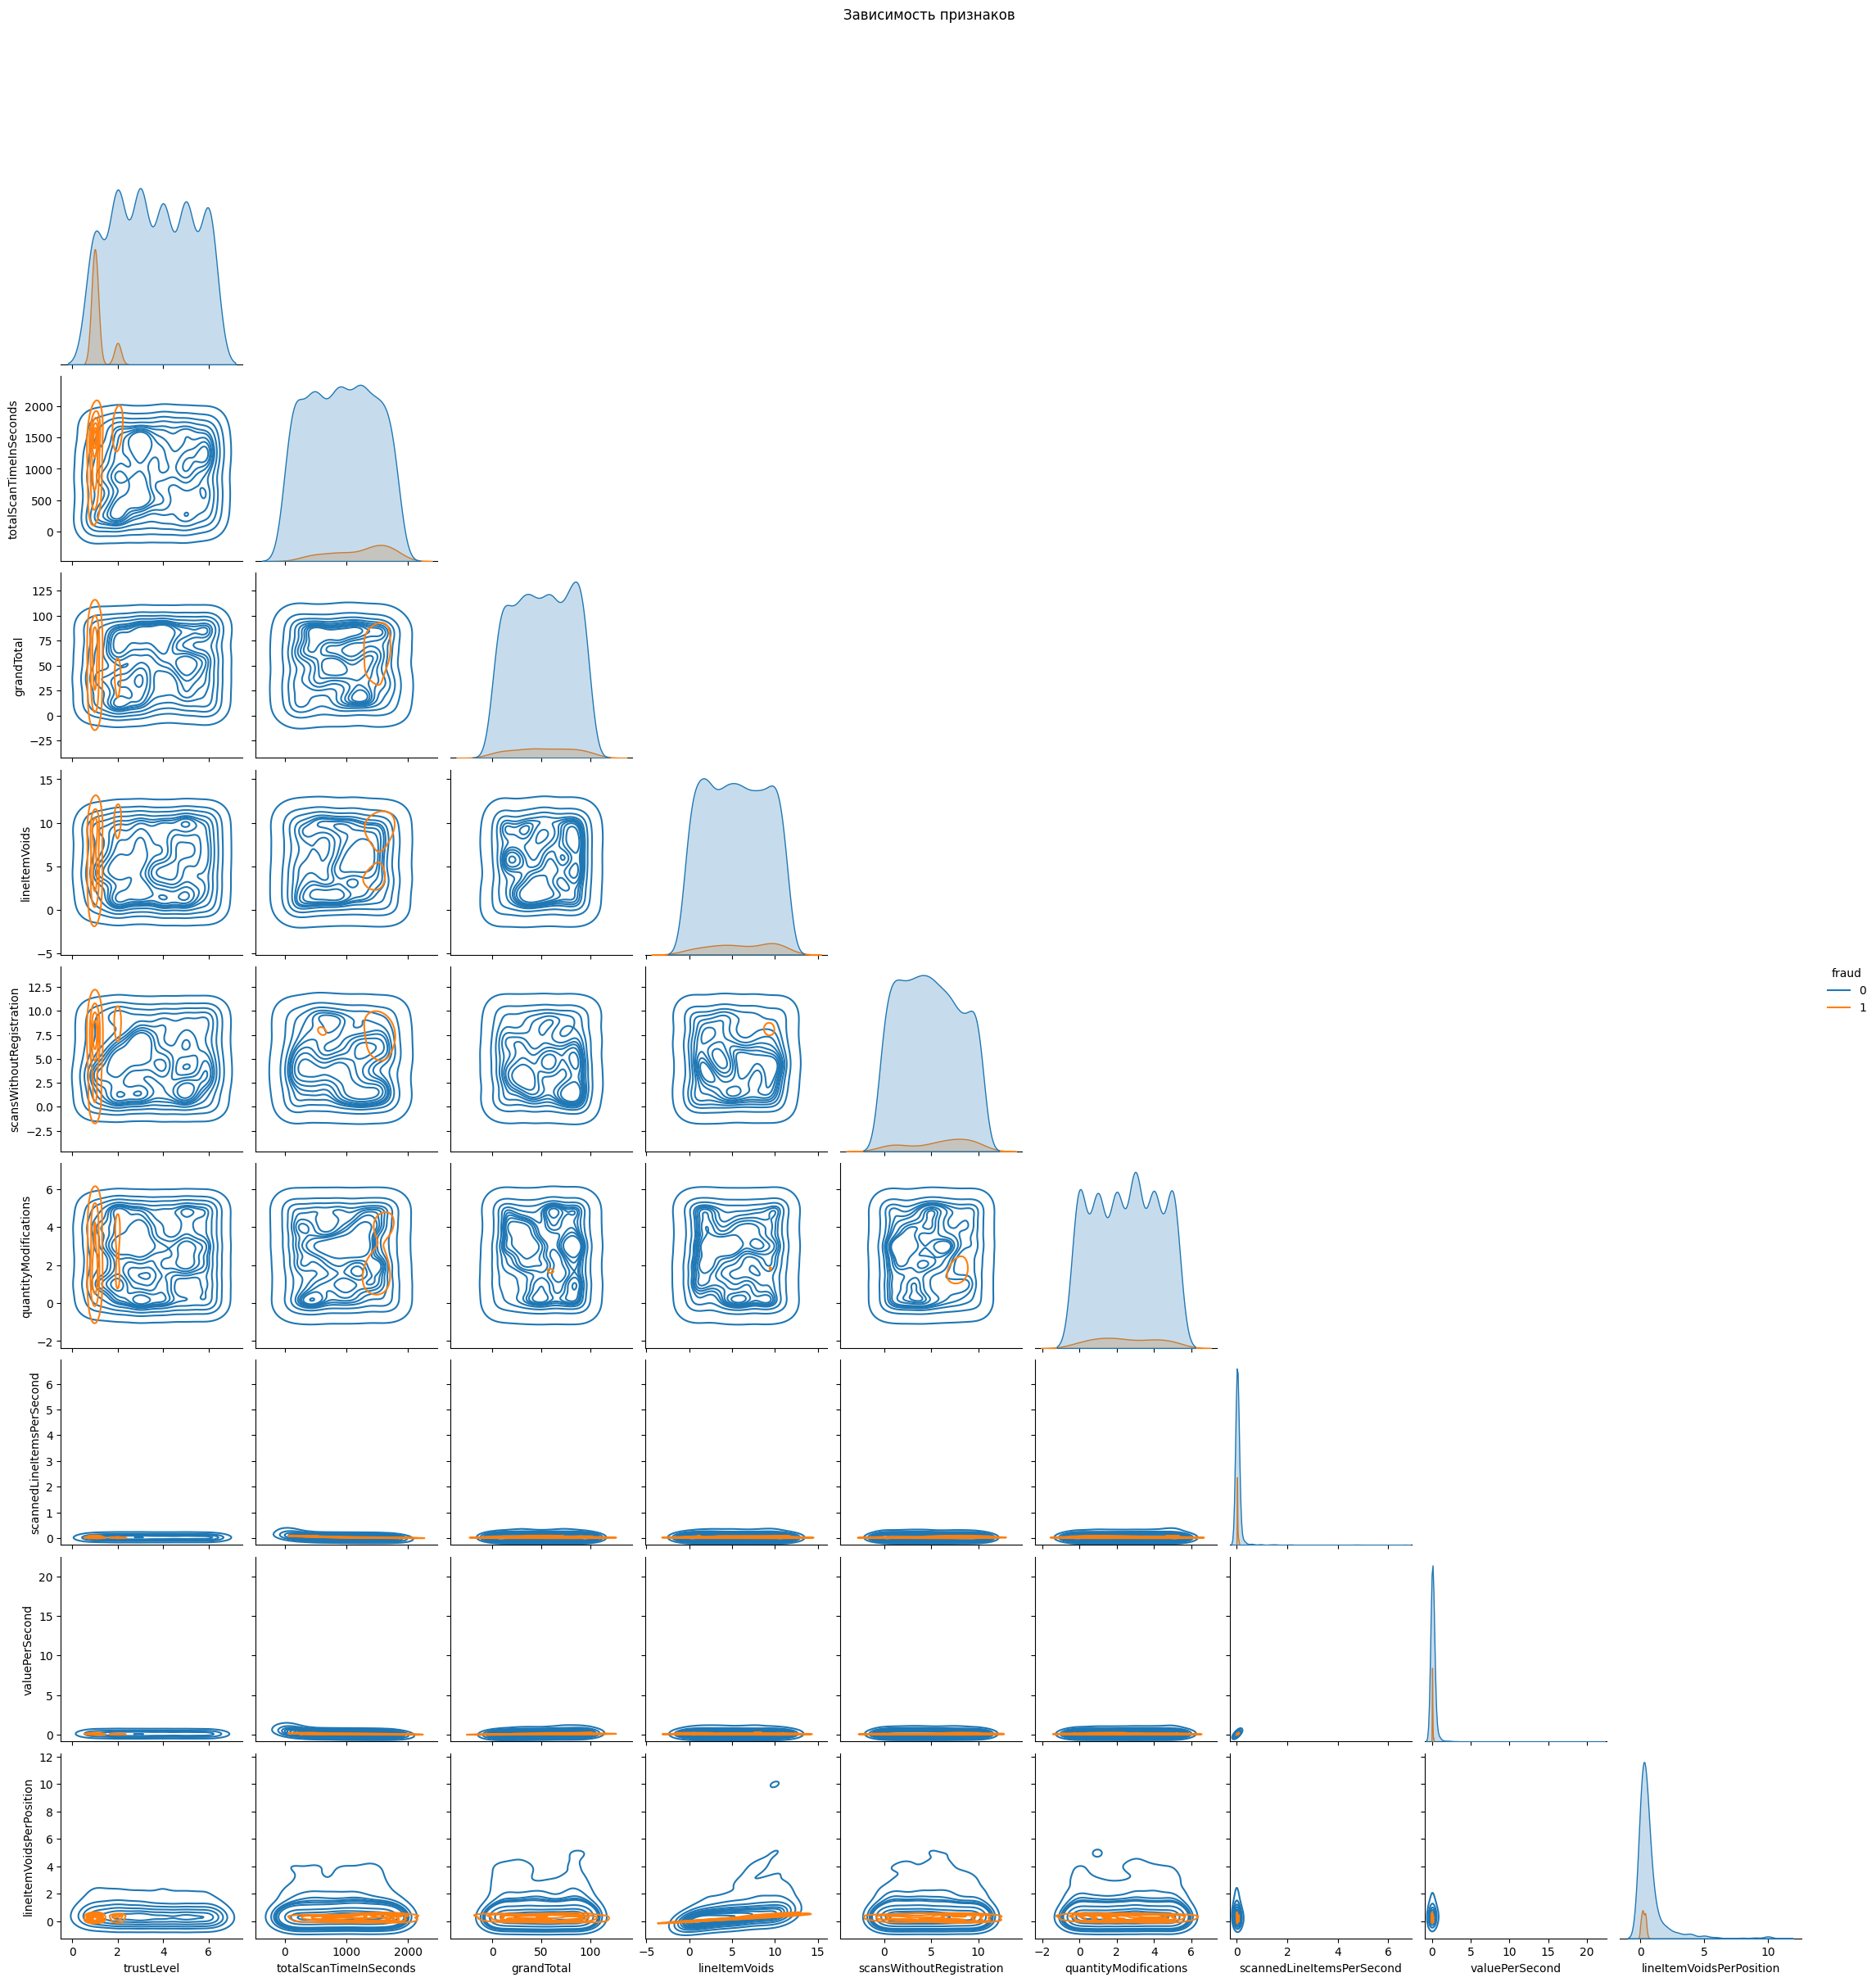

In [25]:
sns.pairplot(df, hue='fraud', corner=True, kind='kde').fig.suptitle('Зависимость признаков', y=1.08);